<a href="https://colab.research.google.com/github/Akshatpattiwar512/Generative-Adversarial-Network/blob/main/Semi_Supervised_GAN_MNIST_Handwritten_Digit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Reshape,Activation,Lambda
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers import BatchNormalization,Dropout,Flatten
from keras.datasets import mnist
from keras.models import Sequential,Model
import keras.backend as K
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Reshape,Activation,Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers import BatchNormalization,Dropout,Flatten
from keras.datasets import mnist
from keras.models import Sequential,Model
import keras.backend as K
import matplotlib.pyplot as plt

In [2]:
img_rows = 28
img_cols = 28
channels = 1
 
img_shape = (img_rows,img_cols,channels)
 
z_dim = 100
num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step
-1.0


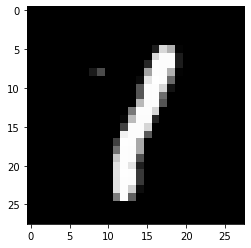

In [3]:
class Dataset:
  def __init__(self,num_labeled,num_classes):
    self.num_labeled = num_labeled
    self.num_classes = num_classes
    (self.x_train,self.y_train),(self.x_test,self.y_test) = mnist.load_data()
  
    def preprocess_image(x):
      x = (x.astype(np.float32)-127.5)/127.5
      x = np.expand_dims(x,axis=-1)
      return x
  
    def preprocess_labels(y):
      return y.reshape((-1,1))
    self.x_train = preprocess_image(self.x_train)
    print(np.min(self.x_train))
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_image(self.x_test)
    self.y_test = preprocess_labels(self.y_test)
 
  def batch_labeled(self,batch_size):
 
    sample_per_class = int(self.num_labeled/self.num_classes)
    imgs = list()
    labels = list()
    for i in range(sample_per_class):
      idx = self.y_train==i
      idx = [i for i, x in enumerate(idx) if x]
      x_classes= self.x_train[idx]
      y_classes = self.y_train[idx]
      #index = np.random.randint(0,x_classes.shape[0],sample_per_class)
      index = np.arange(sample_per_class)
      x_imgs = x_classes[index]
      y_imgs = y_classes[index]
      
      #print(x_imgs.shape)
      [imgs.append(x_imgs[j]) for j in index ]
      [labels.append(y_imgs[j]) for j in range(num_classes)]
 
    imgs = np.asarray(imgs)
    
    labels = np.asarray(labels)
    #print(labels)
 
    ix  = np.random.randint(0,self.num_labeled,batch_size)
    imgs = imgs[ix]
    labels = labels[ix]
    #print(labels.shape)
    return imgs,labels
 
  def batch_unlabeled(self,batch_size):
    idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
    imgs = self.x_train[idx]
    return imgs
 
  def training_set(self):
     x_train = self.x_train[range(self.num_labeled)]  
     y_train = self.y_train[range(self.num_labeled)]
     return x_train ,y_train
  def testing_set(self):
    return self.x_test,self.y_test
 
num_labeled = 100
num_classes = 10
dataset = Dataset(num_labeled,num_classes)
i= dataset.batch_unlabeled(32)
plt.imshow(i[0,:,:,0],cmap='gray')
#print(l[0])

In [4]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=2,padding='same',activation='tanh'))
  #model.add(Activation('tanh'))

  return model

In [5]:
def build_discriminator(img_shape):
  inp = Input(shape=img_shape)

  X = Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same')(inp)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(64,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(128,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Flatten(name="flatten")(X)
  X = Dropout(0.5)(X)
  X = Dense(num_classes)(X)
  model = Model(inputs=inp,outputs=X)
  return model

In [6]:
def build_discriminator_supervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  model.add(Activation('softmax'))
  return model

In [7]:
def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
  model.add(Lambda(custom_activation))
  
  return model

In [12]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
x_test,y_test = dataset.testing_set()
y_test = to_categorical(y_test,num_classes)

In [17]:
supervised_losses = []
iteration_checkpoints = []
accuracies = []
val_losses = []
def train(iterations,batch_size,sample_interval):

  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    imgs,labels = dataset.batch_labeled(batch_size)
    
    #print(labels)
    labels = to_categorical(labels,num_classes=num_classes)

    unlabeled_imgs = dataset.batch_unlabeled(batch_size)

    z = np.random.normal(0,1,(batch_size,z_dim))
    
    fake_imgs = generator.predict(z)
    #print(fake_imgs.shape)

    d_supervised_loss,accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_unsupervised_loss_real = discriminator_unsupervised.train_on_batch(unlabeled_imgs,real)
    d_unsupervised_loss_fake = discriminator_unsupervised.train_on_batch(fake_imgs,fake)
    d_unsupervised_loss = 0.5*np.add(d_unsupervised_loss_real,d_unsupervised_loss_fake)

    z = np.random.normal(0,1,(batch_size,z_dim))
    fake_imgs = generator.predict(z)
    generator_loss = gan.train_on_batch(z,real)

    
    if(iteration+1) % sample_interval ==0:
      supervised_losses.append(d_supervised_loss)
      accuracies.append(100*accuracy)
      iteration_checkpoints.append(iteration+1)
      val_loss = discriminator_supervised.evaluate(x=x_test,y=y_test,verbose=0)
      val_losses.append(val_loss[0])
      print("Iteration No.:",iteration+1,end=",")
      print("Discriminator Supervised Loss:",d_supervised_loss,end=',')
      print('Generator Loss:',generator_loss,end=",")
      print('Discriminator Unsuperived Loss:',d_unsupervised_loss,sep=',')
      print('val_loss:',val_loss,sep=',')
      print('Accuracy Supervised:',100*accuracy)
      #sample_images(generator)

In [18]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
iterations = 6000
batch_size = 32
sample_interval = 500
train(iterations,batch_size,sample_interval)

Iteration No.: 500,Discriminator Supervised Loss: 0.0001934442261699587,Generator Loss: [0.06656524538993835, 1.0],Discriminator Unsuperived Loss:,[7.89881551e-06 1.00000000e+00]
val_loss:,[1.1385092735290527, 0.7070000171661377]
Accuracy Supervised: 100.0
Iteration No.: 1000,Discriminator Supervised Loss: 0.0003761963453143835,Generator Loss: [0.06670080125331879, 1.0],Discriminator Unsuperived Loss:,[2.98777422e-06 1.00000000e+00]
val_loss:,[1.220682144165039, 0.6991000175476074]
Accuracy Supervised: 100.0
Iteration No.: 1500,Discriminator Supervised Loss: 0.00023233090178109705,Generator Loss: [0.06565605103969574, 1.0],Discriminator Unsuperived Loss:,[3.29973602e-06 1.00000000e+00]
val_loss:,[1.2437576055526733, 0.7016000151634216]
Accuracy Supervised: 100.0
Iteration No.: 2000,Discriminator Supervised Loss: 0.00014753594587091357,Generator Loss: [0.0670178085565567, 1.0],Discriminator Unsuperived Loss:,[8.77129793e-06 1.00000000e+00]
val_loss:,[1.2529008388519287, 0.70509999990463

In [22]:
_,accuracy = discriminator_supervised.evaluate(x_test,y_test)
print("Test Accuracy:",accuracy)

313/313 [==============================] - 2s 7ms/step - loss: 1.4198 - accuracy: 0.7043
Test Accuracy: 0.7042999863624573


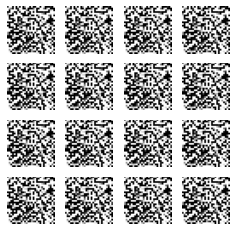

In [27]:
n_rows = 4
fig,axs = plt.subplots(n_rows,n_rows,figsize=(4,4),sharex=True,sharey=True)
z = np.random.normal(0,1,(n_rows**2,z_dim))
#z = z/2 + 0.5
gen_imgs = generator.predict(z)
gen_imgs = gen_imgs/2 + 0.5
count = 0
for i in range(n_rows):
  for j in range(n_rows):
    axs[i,j].imshow(gen_imgs[count,:,:,0],cmap='gray')
    count = count + 1
    axs[i,j].axis('off')

In [24]:
mnist_classifier = build_discriminator_supervised(
                         build_discriminator(img_shape))     

mnist_classifier.compile(loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [25]:
x_train,y_train =dataset.batch_labeled(100)
mnist_classifier.fit(x=x_train,y=y_train,epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 16ms/step - loss: 2.6740 - accuracy: 0.1300
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.9137 - accuracy: 0.6882
Epoch 3/100
4/4 [==============================] - 0s 22ms/step - loss: 0.3957 - accuracy: 0.9447
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2594 - accuracy: 0.9447
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1866 - accuracy: 0.9693
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.1091 - accuracy: 0.9753
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0588 - accuracy: 0.9939
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0458 - accuracy: 1.0000
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0222 - accuracy: 1.0000
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0217 - accuracy: 1.0000
Epoch 11/100
4/4 [=

In [26]:
x,y = dataset.testing_set()
_,accuracy = mnist_classifier.evaluate(x,y)
print("Test Accuracy for fully supervised classifier:",accuracy*100)

313/313 [==============================] - 3s 7ms/step - loss: 1.2676 - accuracy: 0.6086
Test Accuracy for fully supervised classifier: 60.86000204086304
